In [2]:
import sys
sys.path.append("/home/rkube/repos/frnn-loader")

In [3]:
from os.path import join
import unittest
import tempfile
import torch
import numpy as np
import matplotlib.pyplot as plt

import h5py

from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.utils.errors import BadDownloadError

import torch.multiprocessing as mp

In [4]:
root = tempfile.mkdtemp(dir="/home/rkube/tmp")
basedir = "/projects/FRNN/shot_lists"
shotlist_clear = []

num_shots = 10

i = 0

with open(join(basedir, "d3d_clear_100.txt"), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        shotlist_clear.append(shotnr)

        i += 1
        if i >= num_shots:
            break

shotlist_disrupt = []
ttd_list = []
i = 0
with open(join(basedir, "d3d_disrupt_100.txt"), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        shotlist_disrupt.append(shotnr)
        ttd_list.append(ttd)

        i += 1
        if i >= num_shots:
            break

print("shotlist_clear = ", shotlist_clear)
print("shotlist_disrupt = ", shotlist_disrupt)
print("ttd = ", ttd_list)

shotlist_clear =  [167475, 167481, 167482, 167483, 167484, 167485, 167486, 167489, 167490, 167491]
shotlist_disrupt =  [167480, 167487, 167488, 167492, 167494, 167496, 167497, 167498, 167500, 167501]
ttd =  [5.0735, 2.159, 5.269, 7.088, 3.4785, 6.4795, 6.663, 6.4975, 5.2815, 6.87]


In [98]:
"""Instantiate datasets that include TTD transformation"""

my_resampler = resampler_causal(0.0, 10e3, 1e0)

# Instantiate a file backend
my_backend_file = backend_hdf5("/home/rkube/datasets/frnn/")
my_fetcher = fetcher_d3d_v1()
root = root

signal_fs07 = signal_0d("fs07")
signal_q95 = signal_0d("q95")
signal_pinj = signal_0d("bmspinj")
signal_ip = signal_0d("ipspr15V")

ds_clear_list = []
for shotnr in shotlist_clear:
    ds = shot_dataset_disk(shotnr, 
                           predictors=[signal_fs07, signal_q95, signal_pinj, signal_ip], 
                           resampler=my_resampler, 
                           backend_file=my_backend_file, 
                           fetcher=my_fetcher, 
                           root=root,
                           download=True,
                           dtype=torch.float32)

    ds_clear_list.append(ds)
    
ds_disrupt_list = []
for shotnr in shotlist_disrupt:
    ds = shot_dataset_disk(shotnr, 
                           predictors=[signal_fs07, signal_q95, signal_pinj, signal_ip], 
                           resampler=my_resampler, 
                           backend_file=my_backend_file, 
                           fetcher=my_fetcher, 
                           root=root,
                           download=True,
                           dtype=torch.float32)

    ds_disrupt_list.append(ds)

ERROR:root:Unable to load timebase/signal for shot 167475 signal bmspinj
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167475 signal bmspinj
ERROR:root:Unable to load timebase/signal for shot 167475 signal ipspr15V
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167475 signal ipspr15V
ERROR:root:Unable to load timebase/signal for shot 167481 signal bmspinj
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167481 signal bmspinj
ERROR:root:Unable to load timebase/signal for shot 167481 signal ipspr15V
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167481 signal ipspr15V
ERROR:root:Unable to load timebase/signal for shot 167482 signal bmspinj
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167482 signal bmspinj
ERROR:root:Unable to load timebase/signal for shot 167482 signal ipspr15V
ERROR:root:Signal not downloaded: Unable to load timebase/signal for shot 167

In [89]:
ds_c = ds_clear_list[0]
ds_d = ds_disrupt_list[0]

In [96]:
ds_c[:][5000::1000, 1]

tensor([5.9825, 7.6556, 7.6556, 7.6556, 7.6556])

In [22]:
f, q= ds_c[1][0]
print(f,q)

tensor(-4.3378e+11) tensor(12.1682)


In [8]:
ds = ds_clear_list[0]
idx = 0
output = torch.zeros(ds.sum_all_channels, dtype=ds.dtype)
current_ch = 0
with h5py.File(ds.tmp_fname, "r") as fp:
    for pred in ds.predictors:
        tb = fp[f"/transformed/{pred.tag}_trf"]["timebase"]
        data = fp[f"/transformed/{pred.tag}_trf"]["signal_data"]

#     # Access pattern for 0d signals
        if isinstance(pred, signal_0d):
            output[current_ch] = float(data[idx][0])
            
        current_ch += pred.num_channels

In [8]:
# In the future we may want to use this approach
# https://discuss.pytorch.org/t/dataloader-sample-by-slices-from-dataset/113005/5
# dataset = MyDataset()
# sampler = data.BatchSampler(data.RandomSampler(dataset), 4, False)
# loader  = data.DataLoader(dataset, sampler=sampler, batch_size=None)

In [9]:
# Try on-line formulations for standard deviation
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm

# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
# def update(existingAggregate, newValue):
#     (count, mean, M2) = existingAggregate
#     count += 1
#     delta = newValue - mean
#     mean += delta / count
#     delta2 = newValue - mean
#     M2 += delta * delta2
#     return (count, mean, M2)

# # Retrieve the mean, variance and sample variance from an aggregate
# def finalize(existingAggregate):
#     (count, mean, M2) = existingAggregate
#     if count < 2:
#         return float("nan")
#     else:
#         (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
#         return (mean, variance, sampleVariance)

In [10]:
class aggregate:
    """On-line formulations for standard deviation
        
        https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    """
    def __init__(self, shotnr, tag):
        """Initializes class"""
        self.shotnr = shotnr
        self.tag = tag
        self.count = 0
        self.mean = 0.0
        self.M2 = 0.0
        self.variance = float("nan")
        self.finalized = False
        
    def update(self, new_val):
        """Online update of the statistics"""
        self.count += 1
        delta = new_val - self.mean
        self.mean += delta / self.count
        delta2 = new_val - self.mean
        self.M2 += delta * delta2
        
    def __str__(self):
        return f"aggregate {self.tag} - mean={self.mean:e}, variance={self.variance:e} - finalized={self.finalized} count={self.count}"
        
    def finalize(self):
        """Transform M2 to variance"""
        if self.count < 2:
            return float("nan")
        else:
            self.variance = self.M2 / self.count
            self.finalized = True

In [23]:
def calc_stats_online(ds, Q):
    
    # Create a list of aggregators, one for each predictor
    agg_list = [aggregate(ds.shotnr, pred.tag) for pred in ds.predictors]    
    
    # Iterate over dataset 
    for i in range(len(ds)):
        vals = ds[i][0]
        f, q = vals
        
        # Update the aggregators, one-by-one
        for val, agg in zip(ds[i], agg_list):
            agg.update(val.item())

    # Finalize the aggregators
    for agg in agg_list:
        agg.finalize()
    
    # And put them in a queue
    Q.put(agg_list)

In [ ]:
def calc_stats_bulk(ds, Q):
    

In [24]:
Q = mp.Queue()
processes = []

for ds in ds_clear_list:
    p = mp.Process(target=calc_stats, args=(ds, Q))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()


Process Process-3:
Process Process-4:
Traceback (most recent call last):
  File "/home/rkube/.conda/envs/frnn2/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/rkube/.conda/envs/frnn2/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rkube/.conda/envs/frnn2/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/tmp/ipykernel_758083/1425363252.py", line 13, in calc_stats
    agg.update(val.item())
  File "/home/rkube/.conda/envs/frnn2/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
ValueError: only one element tensors can be converted to Python scalars
  File "/tmp/ipykernel_758083/1425363252.py", line 13, in calc_stats
    agg.update(val.item())
ValueError: only one element tensors can be converted to Python scalars


In [13]:
rvs = []

while True:
    try:
        item = Q.get_nowait()
    except:
        break
    rvs.append(item)

In [14]:
rvs[0][0].tag

'fs07'

In [15]:
# compile all aggregators for a single predictor
agg_fs07 = [rv[0] for rv in rvs if rv[0].tag == "fs07"]
print(agg_fs07)

# compile all aggregators for a single predictor
agg_q95 = [rv[1] for rv in rvs if rv[1].tag == "q95"]
print(agg_q95)

[<__main__.aggregate object at 0x20008e245df0>, <__main__.aggregate object at 0x20008e23e160>]
[<__main__.aggregate object at 0x20008e25fd90>, <__main__.aggregate object at 0x200183e84040>]


In [16]:
print(agg_fs07[0])
print(agg_fs07[1])

aggregate fs07 - mean=2.176951e+13, variance=6.708551e+27 - finalized=True count=2000
aggregate fs07 - mean=2.999673e+13, variance=5.274382e+28 - finalized=True count=2000


In [19]:
# Now reduce the aggregators, one-by-one over each shot in the list

n_run = 0
xbar_run = 0.0
M2_run = 0.0


def update_running_stats(n_run, xbar_run, M2_run, agg):
    n_b = agg.count
    delta = agg.mean - xbar_run
    xbar_run = (xbar_run * n_run + agg.mean * agg.count) / (n_run + n_b)
    M2_run = M2_run + agg.M2 + delta * delta * n_run * agg.count / (n_run + agg.count)
    n_run += agg.count

    return (n_run, xbar_run, M2_run)

n_run, xbar_run, M2_run = update_running_stats(n_run, xbar_run, M2_run, agg_q95[0])
print(f"{n_run} {xbar_run:e}, {M2_run/n_run:e}")

n_run, xbar_run, M2_run = update_running_stats(n_run, xbar_run, M2_run, agg_q95[1])
print(f"{n_run} {xbar_run:e}, {M2_run/n_run:e}")


    
# Seed with first element
#na = agg_fs07[0].count
#nb = agg_fs07[1].count
#delta = agg_fs07[1].mean - agg_fs07[0].mean
#xbar_AB = (agg_fs07[0].mean * na + agg_fs07[1].mean * nb) / (na + nb)
#M2AB = agg_fs07[0].M2 + agg_fs07[1].M2 + delta * delta * na * nb / (na + nb)




2000 6.836050e+00, 5.380592e+00
4000 6.815474e+00, 5.204656e+00


In [20]:
n_run = 0
xbar_run = 0.0
M2_run = 0.0


def update_running_stats(n_run, xbar_run, M2_run, agg):
    n_b = agg.count
    delta = agg.mean - xbar_run
    xbar_run = (xbar_run * n_run + agg.mean * agg.count) / (n_run + n_b)
    M2_run = M2_run + agg.M2 + delta * delta * n_run * agg.count / (n_run + agg.count)
    n_run += agg.count

    return (n_run, xbar_run, M2_run)

n_run, xbar_run, M2_run = update_running_stats(n_run, xbar_run, M2_run, agg_fs07[0])
print(f"{n_run} {xbar_run:e}, {M2_run/n_run:e}")

n_run, xbar_run, M2_run = update_running_stats(n_run, xbar_run, M2_run, agg_fs07[1])
print(f"{n_run} {xbar_run:e}, {M2_run/n_run:e}")



2000 2.176951e+13, 6.708551e+27
4000 2.588312e+13, 2.974311e+28


In [44]:
# Now test the parallel algorithm
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#cite_note-:1-3
M2A = agg_fs07_shot1[1] * 2000
M2B = agg_fs07_shot2[1] * 2000

print(agg_fs07_shot1[0], agg_fs07_shot2[0])


n_AB = 2000 + 2000
delta = agg_fs07_shot2[0] - agg_fs07_shot1[0]
M2AB = M2A + M2B + delta * delta * 2000 * 2000 / 4000

print(M2AB / (4000 - 1))

NameError: name 'agg_fs07_shot1' is not defined

In [145]:
# Aggregate stats of fs07 in first shot
agg_fs07_shot1 = [0, 0.0, 0.0]
agg_fs07_shot1_class = aggregate(shotlist_clear[0], "fs07")

# Aggregate stats of fs07 in second shot
agg_fs07_shot2 = [0, 0.0, 0.0]
agg_fs07_shot2_class = aggregate(shotlist_clear[1], "fs07")
# Aggregate stats of q95 in first
agg_q95_shot1 = [0, 0.0, 0.0]
agg_q95_shot1_class = aggregate(shotlist_clear[0], "q95")
# Aggregate stats of q95 in second shot
agg_q95_shot2 = [0, 0.0, 0.0]
agg_q95_shot2_class = aggregate(shotlist_clear[1], "q95")

all_vals_shot1 = torch.zeros((2000, 2))
all_vals_shot2 = torch.zeros((2000, 2))


ds = ds_clear_list[0]
for i in range(len(ds)):
    vals = ds[i]
    f, q = vals

    agg_fs07_shot1 = update(agg_fs07_shot1, f.item())
    agg_fs07_shot1_class.update(f.item())
    
    agg_q95_shot1 = update(agg_q95_shot1, q.item())
    agg_q95_shot1_class.update(q.item())
    
    all_vals_shot1[i, 0] = f.item()
    all_vals_shot1[i, 1] = q.item()
    
agg_fs07_shot1 = finalize(agg_fs07_shot1)
agg_fs07_shot1_class.finalize()
agg_q95_shot1 = finalize(agg_q95_shot1)
agg_q95_shot1_class.finalize()

ds = ds_clear_list[1]
for i in range(len(ds)):
    vals = ds[i]
    f, q = vals

    agg_fs07_shot2 = update(agg_fs07_shot2, f.item())
    agg_fs07_shot2_class.update(f.item())

    agg_q95_shot2 = update(agg_q95_shot2, q.item())
    agg_q95_shot1_class.update(q.item())

    
    all_vals_shot2[i, 0] = f.item()
    all_vals_shot2[i, 1] = q.item()
    
agg_fs07_shot2 = finalize(agg_fs07_shot2)
agg_fs07_shot2_class.finalize()
agg_q95_shot2 = finalize(agg_q95_shot2)
agg_q95_shot1_class.finalize()

In [146]:
print(agg_fs07_shot1)
print(agg_fs07_shot1_class.mean, agg_fs07_shot1_class.variance)
print(all_vals_shot1[:,0].mean(), all_vals_shot1[:, 0].var())

print(agg_q95_shot1)
print(all_vals_shot1[:,1].mean(), all_vals_shot1[:, 1].var())

print(agg_fs07_shot2)
print(all_vals_shot2[:,0].mean(), all_vals_shot2[:, 0].var())

print(agg_q95_shot2)
print(all_vals_shot2[:,1].mean(), all_vals_shot2[:, 1].var())

(21769514773938.17, 6.708550972890995e+27, 6.711906926354173e+27)
21769514773938.17 6.708550972890995e+27
tensor(2.1770e+13) tensor(6.7119e+27)
(6.836049656867986, 5.380592132257209, 5.383283774144281)
tensor(6.8361) tensor(5.3833)
(29996728662872.1, 5.2743823441884055e+28, 5.277020854615713e+28)
tensor(2.9997e+13) tensor(5.2770e+28)
(6.794898147583008, 5.0278727610423966, 5.030387955019907)
tensor(6.7949) tensor(5.0304)


In [147]:
# Now test the parallel algorithm
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#cite_note-:1-3

n_AB = 2000 + 2000
delta = agg_q95_shot2[0] - agg_q95_shot1[0]
xbar_AB = agg_q95_shot1[0] + delta * 2000 * 2000 / 4000
M2A = agg_q95_shot1[1] * 2000
M2B = agg_q95_shot2[1] * 2000
M2AB = M2A + M2B + delta * delta * 2000 * 2000 / 4000

print(M2AB / (4000 - 1))

5.205957297653324


In [148]:
print(torch.cat([all_vals_shot1, all_vals_shot2]).mean(axis=0))
print(torch.cat([all_vals_shot1, all_vals_shot2]).var(axis=0))

tensor([2.5883e+13, 6.8155e+00])
tensor([2.9751e+28, 5.2060e+00])


In [ ]:
### New approach using two-pass algorithms
# Here we first calculate
# E[X] for each signal and each dataset
# Then we distribute this result and 
# in a second pass
# Calculate E[(X - E[X])^2]

In [64]:
# Calculate E[X] for every dataset
# Something is fishy with torch. So roll with numpy for now

def calc_mean_single(ds, done_q):
    # Calculates the mean over every channel
    result = np.array(ds[:].mean(axis=0))
    done_q.put(result)

def calc_var_single(ds, mean_all, done_q):
    # Calculate E[(X - E[X])^2] on each shot
    result = np.array(((ds[:] - mean_all)**2.0).mean(axis=0))
    done_q.put(result)


Q = mp.Queue()
processes = []
for ds in ds_clear_list:
    p = mp.Process(target=calc_mean_single, args=(ds, Q))
    p.start()
    processes.append(p)

for p in processes:
    p.join()

mean_list = []
while True:
    try:
        item = Q.get_nowait()
    except:
        break
    mean_list.append(item)

# This is E[X]
mean_all = np.stack(mean_list, axis=0).mean(axis=0)

# Proceed by calculating E[(X - E[X])^2] for every dataset
processes = []
for ds in ds_clear_list:
    p = mp.Process(target=calc_var_single, args=(ds, mean_all, Q))
    p.start()
    processes.append(p)

for p in processes:
    p.join()

var_list = []
while True:
    try:
        item = Q.get_nowait()
    except:
        break
    var_list.append(item)

# This is E[(X - E[X])^2]
var_all = np.stack(var_list, axis=0).mean(axis=0)



In [65]:
mean_all

array([2.4769397e+13, 6.8739724e+00], dtype=float32)

In [66]:
var_all

array([1.6828717e+28, 6.1402531e+00], dtype=float32)

tensor(-0.0153) tensor(0.9363)
tensor(-0.0319) tensor(0.9051)
tensor(-0.0254) tensor(0.9239)
tensor(-0.0217) tensor(0.9328)
tensor(-0.0216) tensor(0.9385)
tensor(-0.0139) tensor(0.9445)
tensor(-0.0203) tensor(0.9466)
tensor(0.0142) tensor(1.0239)
tensor(0.0894) tensor(1.2529)
tensor(0.0466) tensor(1.1333)


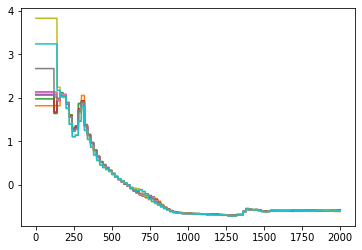

In [87]:
for ds in ds_clear_list:
    data = (ds[:][:,1] - mean_all[1]) / np.sqrt(var_all[1])

    print(data.mean(), data.std())

    plt.plot(data)

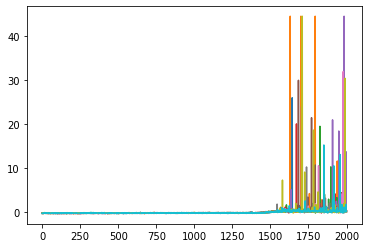

In [85]:
for ds in ds_clear_list:
    plt.plot((ds[:][:,0] - mean_all[0]) / np.sqrt(var_all[0]))